In [2]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn.model_selection import train_test_split #разделение выборки
from sklearn import preprocessing #предобработка
%matplotlib inline
plt.style.use('seaborn')


C:\Users\killr\AppData\Local\Temp\ipykernel_10284\3889490721.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
churn_data = pd.read_csv('churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape
# (2509, 14)

(2509, 14)

In [5]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


In [6]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Давайте расширим наш датасет с помощью методов Feature Engineering. Создадим следующие признаки:

* BalanceSalaryRatio — отношение баланса на счетах к заработной плате клиента;
* TenureByAge — отношение времени пользования банком к возрасту клиента;
* CreditScoreGivenAge — отношение кредитного рейтинга к возрасту клиента.

In [7]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance']/churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure']/(churn_data['Age'])
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore']/(churn_data['Age'])

Также перекодируем единственный текстовый категориальный признак Gender в бинарный столбец (1 — 'Male', 0 — 'Female'):

In [8]:
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x=='Male' else 0)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


Разделим набор данных на матрицу наблюдений X и столбец ответов y:

In [9]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

И, наконец, заранее позаботимся о масштабах признаков. Проведём нормализацию матрицы наблюдений X:

In [10]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, посмотрим на сбалансированность данных.

In [11]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Очевидно, что наши классы не сбалансированы.

При разделении нашего набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет оставлять желать лучшего.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать прекрасное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборках было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=0) 
#stratify как раз отвечает за стратифицируемость разбиения

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))


Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [13]:
print('Train :', y_train.value_counts(normalize=True))
print('\n')
print('Test :', y_test.value_counts(normalize=True))

Train : 0    0.675704
1    0.324296
Name: Exited, dtype: float64


Test : 0    0.675159
1    0.324841
Name: Exited, dtype: float64


In [14]:
#Задание 4.1
#Для начала давайте заранее определим метрику, на которую будем ориентироваться.
#По условию задачи наша модель должна своевременно предсказывать отток клиентов. 
# Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра, 
# а для клиентов, у которых вероятность оттока наиболее высока, — специальные предложения. 
# Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому ложные срабатывания желательно минимизировать. 
# Однако в то же время необходимо сохранить как можно больше клиентов.

#Какую метрику в данной задаче вы будете пытаться улучшить?

#F1

In [15]:
#Задание 4.2
#Обучите модель логистической регрессии на тренировочных данных. 
# Используйте в качестве алгоритма минимизации функции потерь (параметр solver) стохастический градиентный спуск. 
# В качестве значения параметра random_state возьмите 42 для воспроизводимости результатов. Остальные параметры оставьте по умолчанию.

#Предскажите метки классов для тренировочной и тестовой выборок.

#Чему равно значение целевой метрики на тренировочной и тестовой выборках? 
# Ответ приведите с точностью до двух знаков после точки-разделителя.

In [16]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='sag')

In [17]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82      1271
           1       0.63      0.40      0.49       610

    accuracy                           0.73      1881
   macro avg       0.69      0.64      0.65      1881
weighted avg       0.72      0.73      0.71      1881

              precision    recall  f1-score   support

           0       0.75      0.89      0.81       424
           1       0.63      0.38      0.47       204

    accuracy                           0.72       628
   macro avg       0.69      0.63      0.64       628
weighted avg       0.71      0.72      0.70       628



In [18]:
#Задание 4.3
#Сгенерируйте полиномиальные признаки степени 3 для тренировочной и тестовой выборок. 
# Используйте класс PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

#Чему равно количество признаков в тренировочной выборке?

In [19]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test)
#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)

(1881, 454)
(628, 454)


In [20]:
#Задание 4.4

#Обучите модель логистической регрессии на полиномиальных признаках.

#Используйте в качестве алгоритма минимизации функции потерь (параметр solver) стохастический градиентный спуск. 
# Параметру random_state выставите значение 42 для воспроизводимости результатов. 
# Увеличьте максимальное количество итераций, выделяемых на сходимость (параметр max_iter), до 1000.

#Остальные параметры оставьте по умолчанию.

#Предскажите метки классов для тренировочной и тестовой выборок.

#Чему равно значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках? 
# Ответ приведите с точностью до двух знаков после точки-разделителя.

In [21]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_poly, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [22]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1271
           1       0.78      0.56      0.66       610

    accuracy                           0.81      1881
   macro avg       0.80      0.74      0.76      1881
weighted avg       0.80      0.81      0.80      1881

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       424
           1       0.73      0.56      0.64       204

    accuracy                           0.79       628
   macro avg       0.77      0.73      0.75       628
weighted avg       0.79      0.79      0.78       628



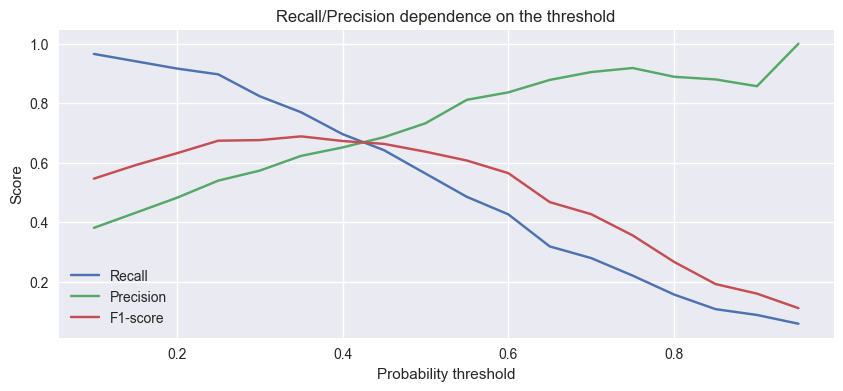

In [23]:
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = log_reg.predict_proba(X_test_poly)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

In [24]:
# 0,35

In [25]:
#Задание 4.6
#Сделайте предсказание классов с подобранным оптимальным порогом вероятности. 
# Чему равно значение целевой метрики на тестовой выборке? Ответ приведите с точностью до двух знаков после точки-разделителя.

In [26]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.35

y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82       424
           1       0.62      0.77      0.69       204

    accuracy                           0.77       628
   macro avg       0.75      0.77      0.76       628
weighted avg       0.79      0.77      0.78       628



In [27]:
#Задание 7.1
#Обучите на обучающей выборке дерево решений с максимальной глубиной 8. 
# В качестве критерия информативности используйте энтропию Шеннона. 
# Минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

#В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

#Сделайте предсказания для тренировочной и тестовой выборок.

#Чему равно значение целевой метрики на каждой из выборок? Ответ округлите до двух знаков после точки-разделителя.

In [29]:
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли

In [30]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    min_samples_leaf=10,
    max_depth=8,
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.72
Test: 0.64


In [ ]:
#Задание 7.2
#Постройте случайный лес из 500 деревьев с максимальной глубиной 8. 
# Критерий информативности — энтропия Шеннона. 
# Минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

#В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

#Сделайте предсказания для тренировочной и тестовой выборок.

#Чему равно значение целевой метрики на каждой из выборок? Ответ округлите до двух знаков после точки-разделителя.

#Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?

In [31]:
rf = ensemble.RandomForestClassifier(
    n_estimators=500,
    max_depth=8,
    criterion='entropy',
    min_samples_leaf=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.74
Test: 0.66


In [ ]:
#Задание 7.4

#Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. 
# Используйте модель, которая показала наилучшее качество.

#В качестве порога вероятности используйте значения из следующего диапазона:

#thresholds = np.arange(0.1, 1, 0.05)
#Напомним, как определить оптимальный порог вероятности:

#Предсказать вероятности оттока для каждого клиента из тестовой выборки.
#В цикле перебирать значения порогов вероятности threshold.
#Сделать предсказание класса по принципу: если вероятность  threshold, отнести объект к классу 1, в противном случае — к классу 0.
#Рассчитать метрику и занести её в заранее созданный список.
#Постройте график зависимости целевой метрики от порога вероятности.

#Какому порогу вероятности соответствует наибольшее значение целевой метрики? Ответ округлите до двух знаков после точки-разделителя.

c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\killr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


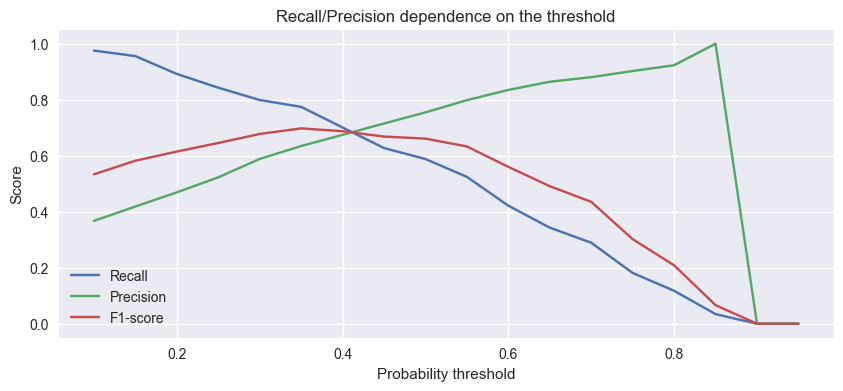

In [33]:
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = rf.predict_proba(X_test)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

In [34]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.35

y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       424
           1       0.63      0.77      0.70       204

    accuracy                           0.78       628
   macro avg       0.76      0.78      0.76       628
weighted avg       0.80      0.78      0.79       628

